![CC](https://i.creativecommons.org/l/by/4.0/88x31.png)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

# Introduction to machine learning

In this notebook, we cover the following topics:

1. Floating point numbers  
  1.1 The IEEE 754 standard  
  1.2 Roundoff error  
  1.2 Truncation error  
2. Exploring parameters spaces  
3. Generating data with simulations  
4. Normalizing data  
5. Feature selection and design  
6. Deep learning  
  6.1 Neural networks  
  6.2 Preparing the data  
  6.3 Optimizing the weights  
  6.4 Dealing with uncertainty  
  6.5 Visualizing prediction errors  
  6.6 Outlook

In [1]:
from glob import glob
from typing import List, Tuple
from os.path import isdir
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
from flowtorch.data import FOAMDataloader

# make results reproducible
pt.manual_seed(0)

# increase plot resolution
plt.rcParams["figure.dpi"] = 160

# create output directory
output = "output"
!mkdir -p $output

## Floating point numbers

You might be wondering why a text on ML starts with a section on floating point numbers. The answer is that a good understanding of how floating point numbers work often helps avoiding pitfalls both in ML and CFD. Computers can not represent real numbers with arbitrary precision, and when designing and implementing numerical algorithms, using the available precision effectively can make the difference between success and failure.

### The IEEE 754 standard and roundoff error

Floating point numbers are the digital representation of real numbers. The IEEE 754 standard defines how exactly most modern computers represent floating point numbers in terms of bits. One bit is always reserved for the sign $S$, and the remaining bits are shared by an integer exponent $E$ and a binary [mantissa](https://en.wikipedia.org/wiki/Significand) $M$. Using these three components, floating point numbers are written as (refer to chapter 1.1.1 in *Numerical Recipes*):
$$
  S \times M \times 2^{E-e},
$$
where $e$ is a fixed machine-dependent constant. In CFD and scientific computing in general, 64 bit floating point numbers are the standard, whereas most ML libraries use 32 bit floating point values as default. Floating point numbers with 32 bit are referred to as *single precision*, and the 64 bit counterpart is termed *double precision*. Single precision operations are more efficient, whereas double precision provides more significant decimal digits. The smallest number that can be still represented by the floating point type on our computer if we add it to $1.0$ is called *machine tolerance*. We can use the NumPy library function [finfo](https://numpy.org/doc/stable/reference/generated/numpy.finfo.html) to investigate mantissa, exponent, and machine tolerance for the most common data type *float32* and *float64*.

In [2]:
for dtype in [np.float32, np.float64]:
    finfo = np.finfo(dtype)
    print(f"dtype: {finfo.dtype}")
    print(f"Number of bits: {finfo.bits}")
    print(f"Bits reserved for mantissa: {finfo.nmant}")
    print(f"Bits reserved for exponent: {finfo.iexp}")
    print("Largest representable number: {:e}".format(finfo.max))
    print("Smallest representable number: {:e}".format(finfo.min))
    print("Machine tolerance: {:e}".format(finfo.eps))
    print(f"Approximately accurate up to {finfo.precision} decimal digits")
    print("-"*46)

dtype: float32
Number of bits: 32
Bits reserved for mantissa: 23
Bits reserved for exponent: 8
Largest representable number: 3.402823e+38
Smallest representable number: -3.402823e+38
Machine tolerance: 1.192093e-07
Approximately accurate up to 6 decimal digits
----------------------------------------------
dtype: float64
Number of bits: 64
Bits reserved for mantissa: 52
Bits reserved for exponent: 11
Largest representable number: 1.797693e+308
Smallest representable number: -1.797693e+308
Machine tolerance: 2.220446e-16
Approximately accurate up to 15 decimal digits
----------------------------------------------


### Roundoff error

We can run a small experiment to observe the consequences of the limited machine tolerance in practice. The floating point data types in PyTorch are named in the same fashion as their NumPy counterparts.

In [3]:
a = pt.tensor(1.0, dtype=pt.float32)
for b in [10**i for i in range(-1, -11, -1)]:
    print("1.0 + {:1.1e} = {:10.10f}".format(b, a+b))

1.0 + 1.0e-01 = 1.1000000238
1.0 + 1.0e-02 = 1.0099999905
1.0 + 1.0e-03 = 1.0010000467
1.0 + 1.0e-04 = 1.0001000166
1.0 + 1.0e-05 = 1.0000100136
1.0 + 1.0e-06 = 1.0000009537
1.0 + 1.0e-07 = 1.0000001192
1.0 + 1.0e-08 = 1.0000000000
1.0 + 1.0e-09 = 1.0000000000
1.0 + 1.0e-10 = 1.0000000000


In the print statement above, we display the result with 10 decimal digits. However, the *float32* type offers only up to 7 significant digits. All additional digits are filled up with somewhat random number. Moreover, when adding values like $10^{-8}$ and smaller, the added small fraction falls victim to the **roundoff** error. After seeing the small experiment above, adding a value in the order of $O(10^{-8})$ to another value that is $O(1)$ will hopefully trigger your roundoff alarm sirens. However, the difficulty with numerical precision is not always so apparent. Consider some data that is $O(10^{-2})$. Now, we want to fit a polynomial to our data, say $y(x) = ax^4+bx^3+cx^2+dx+e$, so we construct the necessary polynomial features by computing the corresponding powers of $x$. The constants are determined using some gradient-based iterative algorithm like gradient decent. At the beginning of the optimization, the weights (coefficients) $a$ to $e$ are typically initialized by sampling random numbers between zero and one. Considering the polynomial form again, most likely the optimization will be affected by roundoff errors (using single precision) because the first term $ax^4$ will be $O(10^{-8})$ and the last term $e$ will be $O(1)$. In practice, we can mitigate such scenarios to some extend by normalizing the data, as we will learn in section 3.

The discrepancy between single precision in ML and double precision in CFD is usually not so critical, especially if ML is used as a means of post-processing CFD data. However, if the ML model is employed somewhere during the simulation, care should be taken. A save option is to set the default precision of the ML library to double precision. In PyTorch, this option can be set globally at the beginning of the program.

In [4]:
x = pt.tensor(1.0)
print(x.dtype)
pt.set_default_dtype(pt.float64)
x = pt.tensor(1.0)
print(x.dtype)
pt.set_default_dtype(pt.float32)

torch.float32
torch.float64


## Truncation error

In contrast to the roundoff error, the truncation error is not a hardware property but results from the discrete approximation of continuous quantities. For example, we could approximate the integral of $y(x) = x^2$:
$$
  \int\limits_0^1 x^2 \mathrm{d}x = 1/3
$$
numerically by using the trapezoidal rule.

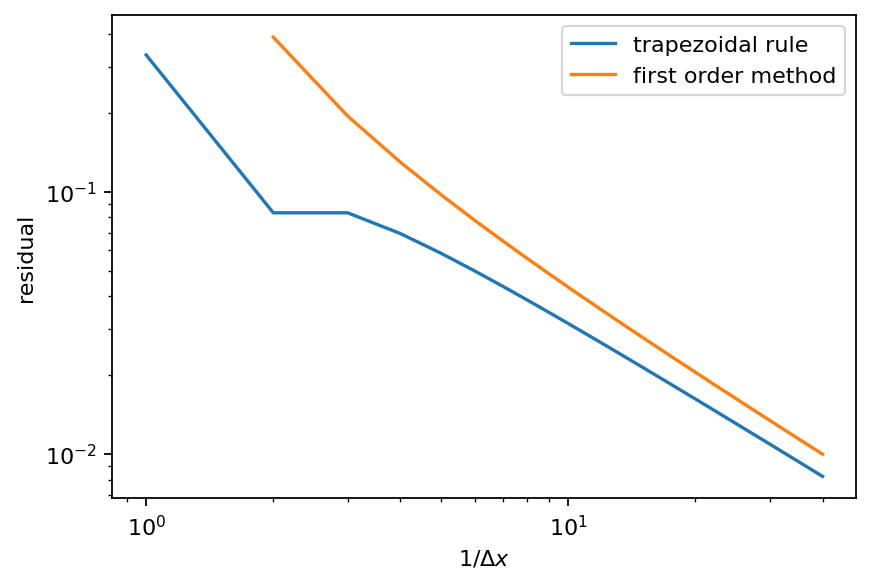

In [5]:
max_intervals = 40
residual = []
for n_int in range(1, max_intervals+1):
    x = pt.linspace(0, 1, n_int)
    y = x**2
    dx = (1.0-0.0) / n_int
    integral = 0.5 * (y[0:-1]+y[1:]).sum() * dx
    residual.append(abs(integral - 1.0/3.0))

plt.plot(range(1, max_intervals+1), residual, label="trapezoidal rule")
plt.plot(range(1, max_intervals+1), pt.linspace(0, 1, max_intervals)
         ** (-1)*0.01, label="first order method")
plt.xlabel(r"$1/\Delta x$")
plt.ylabel("residual")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.savefig(f"{output}/residual_trapezoidal_rule.svg", bbox_inches="tight")

As we can see, the residual decreases proportionally to the size of discrete elements into which we divide the interval. So, even if the computer provided perfect accuracy, it would still take infinitely small elements to reach perfect accuracy. CFD simulations employing the finite volume method are typically second order accurate, so the truncation error decreases proportionally to the square of the element size.

## Exploring parameter spaces

Suppose we want to conduct a CFD parameter study in which we vary the Reynolds number $Re$ and record the drag coefficient $c_d$. Our aim would be to create an ML-based surrogate model based on the pairs $Re_i$ and $c_{d,i}$. Let's assume we know a range for $Re$ that we are particularly interested in. An important question before starting the simulations is now how to pick suitable $Re$ values in the specified range. In general, we want our sampling to be:

1. unbiased - every point has the same chance of being selected
2. efficient - we want to run as few simulations as possible
3. homogeneous - we want the samples to be homogeneously distributed across the parameter space

Let's say we want to run $N_s$ simulations. Intuitively, you may want to distribute the $N_s$ points equally spaced across the Reynolds number range, and there are good arguments to do so. However, there are at least two problems with this approach:

1. it does not scale to multiple dimensions, e.g., if we vary more than one parameter; if we want to treat every parameter equal, we should pick $N_s$ points in every parameter range and perform simulation for all parameter permutations; for $d$ parameters, this strategy would require running $N_s^d$ simulations; the number of sample points increases exponentially
2. it is biased because not every point has the same chance of being sampled; the plot below show a somewhat artificial and extreme effect of bias; the true signal is periodic but the samples suggest that there is basically no correlation between input and output

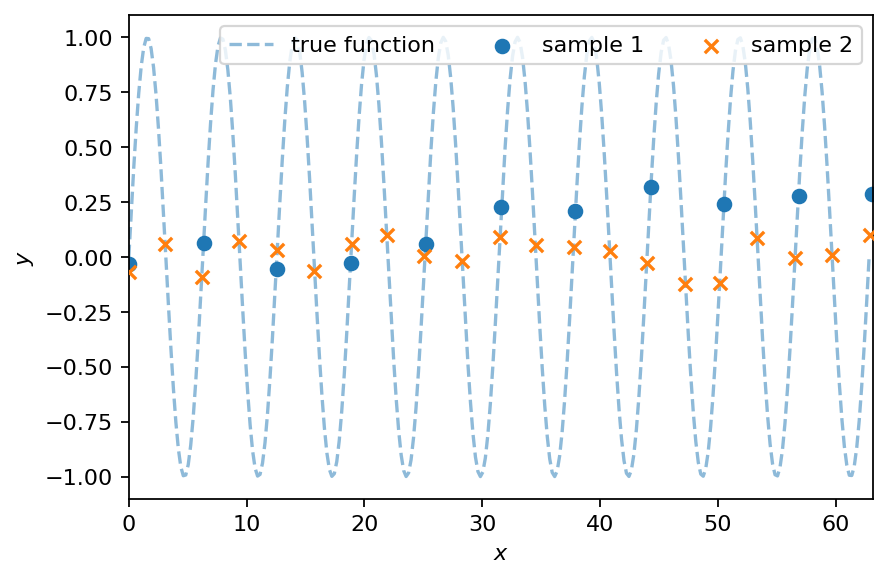

In [6]:
x = pt.linspace(0.0, 20*np.pi, 300)
y = pt.sin(x)

x_sample_1 = pt.linspace(0, 20.1*np.pi, 11) + (2*pt.rand(11)-1)*0.1
x_sample_2 = pt.linspace(0, 20*np.pi, 21) + (2*pt.rand(21)-1)*0.1

plt.plot(x, y, alpha=0.5, ls="--", label="true function")
plt.scatter(x_sample_1, pt.sin(x_sample_1) +
            (2*pt.rand(11)-1)*0.05, label="sample 1")
plt.scatter(x_sample_2, pt.sin(x_sample_2) + (2*pt.rand(21)-1)
            * 0.05, marker="x", label="sample 2", zorder=6)
plt.xlim(0, 20.1*np.pi)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend(ncol=3, loc=1)
plt.savefig(f"{output}/biased_sampling.svg", bbox_inches="tight")

To make the samples unbiased, we should select the samples randomly. However, selecting $N_s$ points at random may give you some stomach ache, too, because large portions of the parameter space might remain unexplored. Random sampling is relatively inefficient.

A good compromise between the homogeneity of equally spaced sample points and efficient unbiased sampling is *latin hypercube sampling* (LHS). If the goal is to perform $N_s$ simulations, each parameter range is equally divided into $N_s$ sections. Then, one random sample is drawn in each section of each parameter. If there is more than one parameter, the samples drawn from the individual parameter ranges are shuffled. Combining (stacking) the shuffled individual samples yields the final samples in the full parameter space. Below, we implement a simple version of LHS in PyTorch. 

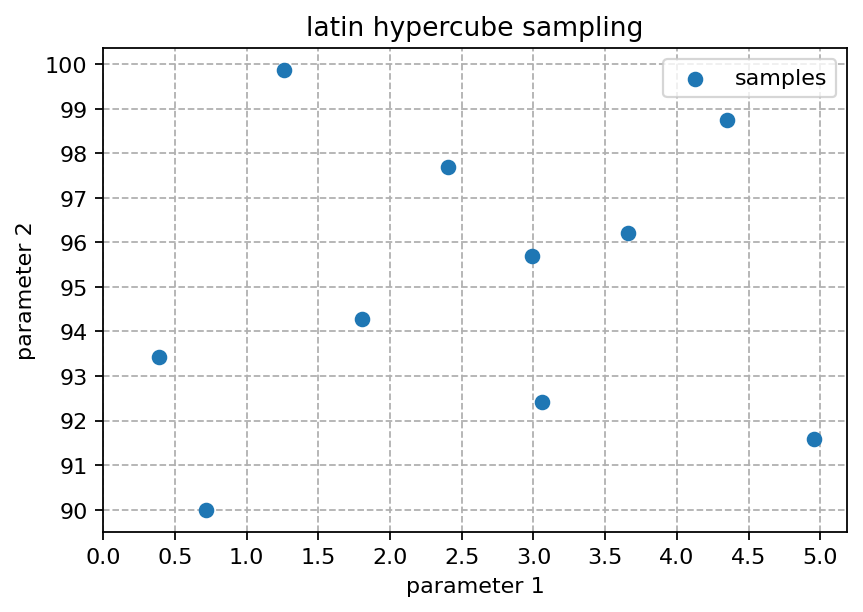

In [7]:
def lhs_sampling(x_min, x_max, n_samples):
    assert len(x_min) == len(x_max)
    n_parameters = len(x_min)
    samples = pt.zeros((n_parameters, n_samples))
    for i, (lower, upper) in enumerate(zip(x_min, x_max)):
        bounds = pt.linspace(lower, upper, n_samples+1)
        rand = bounds[:-1] + pt.rand(n_samples) * (bounds[1:]-bounds[:-1])
        samples[i, :] = rand[pt.randperm(n_samples)]
    return samples


N_s = 10
samples = lhs_sampling([0, 90], [5, 100], N_s)
plt.scatter(samples[0, :], samples[1, :], zorder=6, label="samples")
plt.xticks(pt.linspace(0, 5, N_s+1))
plt.yticks(pt.linspace(90, 100, N_s+1))
plt.grid(True, ls="--")
plt.legend()
plt.xlabel("parameter 1")
plt.ylabel("parameter 2")
plt.title("latin hypercube sampling")
plt.savefig(f"{output}/lhs_sampling.svg", bbox_inches="tight")

## Generating data from simulations

The previous section covered how to sample a parameter space efficiently and unbiased. This section outlines some tools and strategies to run automated CFD parameter studies. Every parameter study should start with a tested and validated base simulation. Typical criteria for a good base simulation are similar to the ones of any good CFD simulation:

- the setup correctly reflects the mathematical problem
- a mesh dependency study was performed, and the results show sufficiently low mesh dependency
- key performance quantities were validated against high-fidelity reference data
- the setup is optimized; mesh-independent results are obtained as quickly as possible

The easiest way to perform a parameter study is to create a copy of the base simulation, modify the parameters in question, and run the new setup. However, the change of one parameter often requires the adjustment of related settings, too. For example, increasing the inlet velocity or the pressure gradient driving the flow leads to an increased Courant number if the mesh remains unchanged. Since the increased Courant number might cause stability issues, the numerical time step should be lowered. Tools like OpenFOAM support time step adjustment based on the maximum Courant number, which simplifies parameter changes to some extend. If the time step needs adjustment, the characteristic time scale of the problem has probably changed, too. For example, the vortex shedding frequency displayed by the flow past a cylinder increases proportionally to the Reynolds number in the range $80 < Re < 1000$. If our aim is to run the simulation until a quasi-steady vortex shedding is reached, the required physical simulation time decreases as the Reynolds number increases. Running all simulation up to the same physical end time would be a waste of resources.

On the other hand side, changing too many parameters at once might make the setup unnecessarily complex and could introduce unforeseeable side effects. Mesh generation, for example, is often an intricate and time consuming process, such that we may want to run all simulations employing the same mesh. However, how do we ensure that the results remain mesh independent despite an increase, say, of the Reynolds number? A simple strategy for this scenario would be to pick the most demanding case in terms of mesh resolution and to build the mesh based on this configuration. Of course, the computational efficiency for less demanding cases decreases, but building optimized meshes for all conditions might be untractable.

Once the base case is ready, we can write a script that copies, modifies, and runs new setups. Shell or Python scripts are good choices to automate the process. Shell programming is a good option for simple parameter variations and to automate workflows in general. The *Allrun* scripts provided in the *test_cases* are simple recipes to perform a list processing steps required to perform the simulation. Python scripts are more powerful but require a Python interpreter and possibly additional library dependencies. Python also allows executing shell commands via the standard library functions [os.system()](https://docs.python.org/3/library/os.html#os.system) or [subprocess.Popen()](https://docs.python.org/3/library/subprocess.html#subprocess.Popen). The *system* function is rather limited but sufficient for running simple and short shell commands. For example, the lines
```
cmd = "sed -i 's/old_text/new_text/' exampleDict"
os.system(cmd)
```
would search the file *exampleDict* for the string *old_text* and replace the text with *new_text*. On the other hand side, *Popen* offers greater flexibility in terms of process control. The same command as above executed with *subprocess* would be:

```
cmd = ["sed", "-i", "'s/old_text/new_text/'", "exampleDict"]
p = subprocess.Popen(cmd)
# print exit code to check if execution was successful
print(p.poll())
```

In the case of OpenFOAM simulations, the *Popen* function is a good candidate to perform individual simulations:

```
def run_simulation(path):
    pwd = getcwd()
    chdir(path)
    p = Popen(["./Allrun.singularity"]).wait()
    chdir(pwd)
    if p.poll() == 0:
        print(f"Success: simulation {path} completed")
    else:
        print(f"Error: simulation {cmd} not completed")
```
If we had a list of paths to modified simulations, we could loop over the list and use the *run_simulation* function to execute one simulation after the other. We can accelerate the execution process if we have enough resources to perform multiple simulations at once. Python supports running multiple processes at once via the *multiprocessing* module. A suitable workflow making use of the *run_simulation* function defined before, would be to create a process pool based on the number of available CPU cores and to map all the list of all simulation paths to the *run_simulation* function:
```
simulations = ["./sim_0/", "./sim_1/", "./sim_2/"]
pool = Pool(2)
with pool:
    pool.map(run_simulation, simulations)
```
Employing the code snippet above, simulations zero and one would be run roughly at the same time. Whichever subprocess finishes first will then execute simulation two.

## Normalizing data

Suppose we created a dataset, in which an airfoil's drag coefficient was determined for several Reynolds numbers $Re$ and angles of attack $\alpha$. The Reynolds number ranges between $Re=10\times 10^6$ and $Re=20\times 10^6$. The angle of attack was varied between $\alpha = 0^\circ$ and $\alpha = 4^\circ$. Now we want to build a surrogate model by means of regression. Based on section 1, it should be clear that combining the features $Re$ and $\alpha$ directly in a model is not a good idea. So, how can we improve the situation? A simple solution is to normalize both features. There are two common ways to normalize any kind of data. In a min-max-scaling, each feature $x_i$ are scaled to the range $[0,1]$:
$$
  \tilde{x}_i = \frac{x_i-x_{i,min}}{x_{i,max}-x_{i,min}}.
$$
Alternatively, the equation above could also be rescaled to the range $[-1,1]$. Min-max scaling works great if the input data are clean, e.g., if there are no outliers. A normalization technique less sensitive to outliers scales the features with their mean $\mu_x$ and standard deviation $\sigma_x$:
$$
  \tilde{x}_i = \frac{x_i-\mu_{x_i}}{\sigma_{x_i}}.
$$
The re-scaled features have zero mean and unit standard deviation. These properties are also the reason why this scaling is a good choice when training neural networks employing sigmoid and hyperbolic tangents activation functions. These activation functions are not so popular any longer in most fields using deep learning. However, for PINNs they are essential because one can compute arbitrarily many derivatives of both functions. Without going further into detail about neural networks, it is sufficient to now that we do not want activation functions to *saturate*, which mean to become insensitive to the input. Looking at the sigmoid function depicted below, saturation occurs if the argument becomes too small or too low. Data normalized by their mean and standard deviation lead to activation values in the most sensitive range (the slope is the highest around $x=0$).

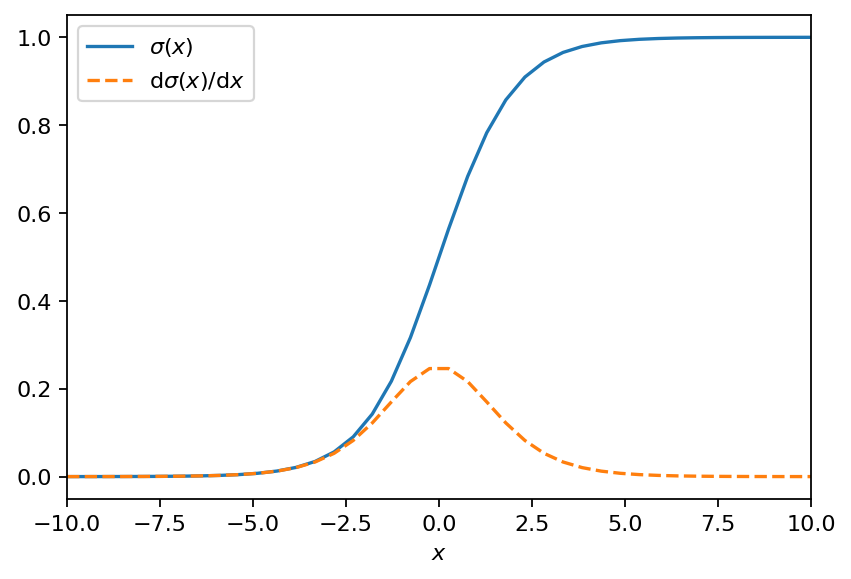

In [8]:
def sigmoid(x: pt.Tensor) -> pt.Tensor:
    """Compute the sigmoid function.

    :param x: input argument
    :type x: pt.Tensor
    :return: sigmoid of x
    :rtype: pt.Tensor
    """
    return 1.0 / (1.0 + pt.exp(-x))


x = pt.linspace(-10, 10, 40)
plt.plot(x, sigmoid(x), label=r"$\sigma (x)$")
plt.plot(x, sigmoid(x)*(1.0-sigmoid(x)), ls="--",
         label=r"$\mathrm{d}\sigma (x)/\mathrm{d} x$")
plt.xlabel(r"$x$")
plt.xlim(-10, 10)
plt.legend()
plt.savefig(f"{output}/sigmoid_function.svg", bbox_inches="tight")

Clustering is another great example to demonstrate the importance of normalization. Suppose we have the following data points for Reynolds number $Re$ and lift coefficient $c_l$:

| $i$ | $Re$ | $c_l$ |
|:---:|:----:|:--------:|
| 1 | $10\times 10^6$ | $0.3$ |
| 2 | $12\times 10^6$ | $0.12$ |
| 3 | $15\times 10^6$ | $0.11$ |

Clustering is about grouping similar data points. Eyeballing the data, you probably see that something significant must have happened in the range $10\times 10^6 < Re < 12\times 10^6$ because the lift dropped to about one third for the measurement points 2 and 3. If you were tasked to sort similar data points into two different bins, you would probably separate point 1 from the points 2 and 3. To automate the clustering, we need a more precise definition of the notion of similarity we used so far. The most common metric to measure the distance between data points is the [Euclidean norm](https://en.wikipedia.org/wiki/Euclidean_distance). For the data point above, the distances are:

| points | distance |
|:------:|:--------:|
| 1-2 | $2\times 10^6$ |
| 1-3 | $5\times 10^6$ |
| 2-3 | $3\times 10^6$ |

According to the Euclidean distance, we should rather group points 1 and two together because the distance between them is the smallest. Of course, this outcome is not really what we wanted. Again, normalization can help the situation. The min-max-normalized data are:

| $i$ | $\tilde{Re}$ | $\tilde{c}_l$ |
|:---:|:----:|:--------:|
| 1 | $0$ | $1$ |
| 2 | $0.4$ | $0.05$ |
| 3 | $1$ | $0$ |

The distances between the points are now:

| points | distance |
|:------:|:--------:|
| 1-2 | $1.03$ |
| 1-3 | $1.41$ |
| 2-3 | $0.60$ |

This time, the distance reflects out initial evaluation. The distance between points 2 and 3 is the smallest. In higher dimensions, seeing such normalization-related issue is not straight forward. Therefore, it is good practice to **always** normalize all the data, features as well as labels. In the worst case, normalization costs you a few extra operations to scale and re-scale the model's input and output. In most cases, normalization improves accuracy and accelerates the training.

Finally, if the data points of a feature are very unevenly distributed in the feature space, it might be sensible to work with the logarithm of the feature instead of the feature itself. An example displaying the usefulness of logarithmic scaling is part of the next lecture.

## Feature selection and design

Selecting and designing good features is one of the most essential parts of applying ML to CFD problems. Sometimes, the features and labels are naturally given, and it is straight forward to identify the mapping that the ML model has to perform. Suppose we have a car model and want to create a surrogate model predicting the drag as a function of the Reynolds number based on a couple of CFD simulations. In the simulation, the inlet velocity may be defined to impose a certain Reynolds number und the aerodynamic forces acting on the car result from the velocity and pressure fields. There would be only one feature and one label, and we could choose from a variety of regression algorithms to build a suitable surrogate model. However, sometimes it can be sensible to design additional features based on the extracted raw data. Potential reasons for designing new features could be:

- to enforce mathematical constraints like symmetry or boundedness
- to leverage known (physical) relations
- to reduce the variance in the data before training

In summary, one could say that feature design serves the purpose to simplify the ML problem. Good features accelerate the model training and often lead to smaller yet more accurate models. However, care has to be taken when selecting or designing features. It is essential to know right from the beginning what exactly the model is going to be used for in a target application. One common pitfall is basing the model on features that are not (easily) available in the target application. For example, when deriving models for low-fidelity simulations based on high fidelity data, we must first convert the high-fidelity data into features that are also available during the runtime of the low-fidelity simulation. To give a more specific example, direct numerical simulations (DNS) data may be used for turbulence modeling in large eddy simulation (LES) or Reynolds-averaged Navier-Stokes (RANS) simulation approaches. In all approaches, there is going to be a *velocity field*. However, the mathematical definition of velocity and other quantities varies in each simulation. DNS provides spatially and temporally resolved fields, while LES works with filtered and RANS with time-averaged information. Therefore, the first processing step should be to filter or average the DNS data before exploring and designing new features. Not only the mathematical definition of features but also assumptions about the spatial arrangement might be important. For example, DNS solvers might operate on structured Cartesian meshes, while solver for industrial applications operate on unstructured meshes with arbitrary topology. While it might seem a good idea at first to use specialized neural network architectures like convolutional neural networks to process the array-like DNS data, such a model would be hard or even impossible to apply in the unstructured target solver.

A general rule of thumb for designing additional features is to have rather too many than too few features. Not all features should and will be used for model training since the model may become unnecessary complex or prone to over-fitting the data. However, instead of eliminating features manually, one could consider employing feature exploration and selection strategies. Some examples are:

 - [correlation heatmaps](https://stackoverflow.com/questions/39409866/correlation-heatmap) visualize the linear correlation between different features and labels; if the correlation between a feature and a label is strong, the feature might be a good candidate for modeling
 - sequential forward/backward selection performs eliminatory rounds with varying numbers and combinations of features; each round, one feature is removed (backward selection) or added (forward selection)
 - decision trees or ensemble variants thereof have a built-in [feature importance](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) to rank features (based on the internal criteria at each node of the tree)
 - [permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance) shuffles the values of a single feature randomly and observes how the performance of a training model is affected

 The feature ranking strategies have different pros and cons. Sequential backward selection, for example, yields a meaningful ranking in most cases but can be very expensive to compute. Decision trees, on the other hand, are easily trained, but their *feature importance* is more susceptible to small changes in the data.

## Deep learning

### Neural networks

Deep learning (DL) is a sub-field of ML that focuses on the design, implementation, and optimization of deep neural networks. Neural networks form a class of parametrized functions characterized by great approximation capabilities, especially if high-dimensional mappings from features to labels are required. The functional form of neural networks is inspired by the [perceptron](https://en.wikipedia.org/wiki/Perceptron), which was the first mathematical approach to explain to working of neurons (nerve cells) in the brain. The building blocks of modern neural networks still have some resemblance with the original perceptron, but many modifications have been introduced. These modifications are largely driven by empirical observations and mathematical intuition. In this lecture, we introduce the mathematical form of relatively simple feed-forward neural networks with fully connected layers and use them as black box function approximation tool. In the next lecture, we develop some more intuitive understanding for the way how networks approximate functions based on data.

The picture below depicts a feed-forward neural network with its typical components: input and output layers, hidden layers, neurons with activations, bias units, and connections between these components.

<img src="media/example_nn.png" style="width:600px">

In the input layer, one neuron is reserved for each possible feature $x_i$ of the feature vector $\mathbf{x} = \left[x_1, x_2, ..., x_{N_f}\right]^T$, where $N_f$ is the number of features. The network sketched above has two neurons for two input features, so $N_f = 2$. The connections between the input and the first hidden layer represent free parameter, also called weights. If each neuron of one layer is connected with each layer of the consecutive layer, the layers are said to be fully connected. Fully connected layers form part of almost any modern neural network architecture. In every neuron $j$ of a hidden layer $l$, a weighted sum $z_j^l$ of all $N_{neu}^{l-1}$ neurons (features) of the previous layer $l-1$ is computed:
$$
  z_j^l\left(\mathbf{x}^{l-1}\right) = \sum\limits_{i=1}^{N_{neu}^{l-1}} w_{ji}^{l-1} x_i^{l-1} = \left(\mathbf{W}^T \mathbf{x}\right)^{l-1}.
$$
The coefficients $w_{ij}$ of weight matrix $\mathbf{W}$ are represented by the lines connecting pairs of neurons in the sketch above. The weighted sum is then transformed by a typically non-linear function $a(z)$, which is also called activation function. Typical activation functions will be covered in some of the following paragraphs. The activation function combines and transforms the features of the previous layer. Therefore, one could interpret the activation signal of the $j$th neuron in layer $l$ as a new features $x_j^l$:
$$
  x_j^l = a_j^l\left(z_j^l(\mathbf{x}^{l-1})\right).
$$
Following the notion of transformed features, the aggregation of all $N_{neu}^l$ neurons in layer $l$ forms a new feature vector $\mathbf{x}^l$:
$$
  \mathbf{x}^l = \mathbf{a}^l = \left[a_1^l, a_2^l, ..., a_{N_{neu}^l} \right]^T.
$$
The re-combination of the feature vector in each of the network's layers may be written as a repeated function composition $f(g(x)) = f\circ g(x)$. Evaluating the function composition layer by layer would be termed *forward pass* and ultimately defines the neural network model $f_{\mathbf{p}}(x)$:
$$
  f_{\mathbf{p}}(\mathbf{x}) = \mathbf{x}^{N_L} \circ \mathbf{x}^{N_{L-1}}\circ ... \circ \mathbf{x}^1 (\mathbf{x}),
$$
where $\mathbf{x}$ is the original feature vector provided by the input layer and $N_L$ is the number of layers. For convenience of notation, we may stack all weight matrices $\mathbf{W}^l$ in a long parameter vector $\mathbf{p}$ associated with the model. The model sketched above yields exactly one label. However, in general the label vector $\mathbf{y} = \left[y_1, y_2, ..., N_l\right]^T = f_{\mathbf{p}}(x)$ may be vector-valued with entry for each one of the $N_l$ labels.

Evaluating the model for a concrete feature vector $\mathbf{x}_i$ is yields a prediction, typically denoted by $\hat{\mathbf{y}}_i$:
$$
  \hat{\mathbf{y}}_i = f_{\mathbf{p}}(\mathbf{x}_i).
$$
Training a neural networks means optimizing the free parameters $\mathbf{p}$ such that all predictions $\hat{\mathbf{y}}_i$ match the true labels $\mathbf{y}_i$ closely. The precise formulation and implementation of the optimization problem follows in the next sections.

An essential element of neural networks are the activation functions applied to the weighted sum at each neuron. There are a few heuristic criteria for suitable activation function:

- nonlinear
- continuous with infinite support
- monotonic
- constant slope
- effectively computable

There is no single activation function suiting all of the above requirements at once. The activation functions of hidden layers should be always nonlinear, because otherwise, the fully connected layers basically form a polynomial with many redundant coefficients. Only the output layer might employ a linear activation, e.g., for regression problems. For classification problems, there are specialized activation functions converting the input into a probability of the logarithm thereof. The most common activation functions for hidden layers are depicted below.

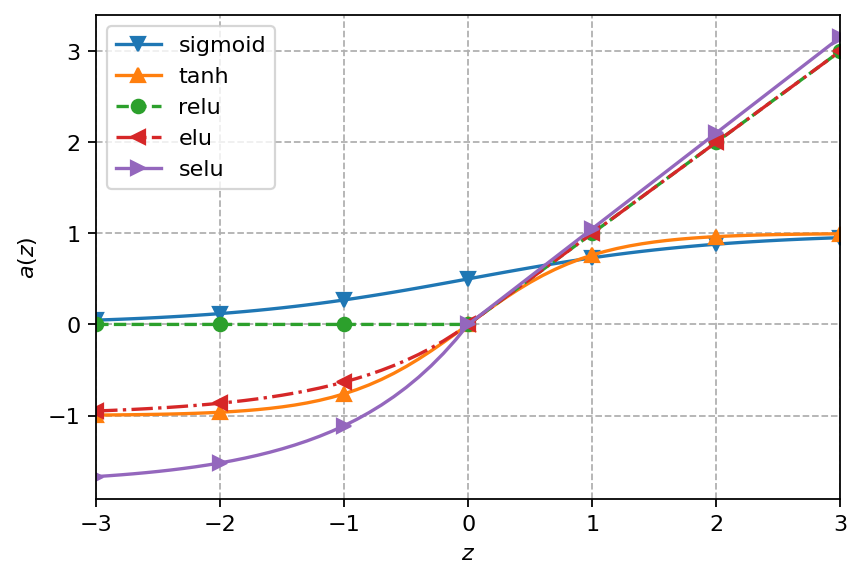

In [9]:
activations = [
    pt.sigmoid,
    pt.tanh,
    pt.nn.functional.relu,
    pt.nn.functional.elu,
    pt.nn.functional.selu
]

x = pt.arange(-3, 3.01, 0.1)
marker = ["v", "^", "o", "<", ">"]
ls = ["-", "-", "--", "-.", "-"]
for i, func in enumerate(activations):
    plt.plot(x, func(x), ls=ls[i],  marker=marker[i], markevery=10, label=func.__name__)
plt.xlim(-3,3)
plt.xlabel(r"$z$")
plt.ylabel(r"$a(z)$")
plt.grid(True, ls="--")
plt.legend()
plt.savefig(f"{output}/activation_functions.svg", bbox_inches="tight")

For many problems, the rectified linear unit (ReLU) leads to fast and accurate models. In general, it is fair to say that training with exponential linear units (ELU), scaled exponential linear units (SELU), and ReLU converges significantly faster than with hyperbolic tangents or sigmoid. For a mathematical definition of these function, refer to [this article](https://en.wikipedia.org/wiki/Activation_function). On the other, functions with higher smoothness also lead to models with higher smoothness. Models employing ReLU only may have kinks and non-constant derivatives. However, ReLUs are also significantly faster to compute since they, in contrast to the other functions mentioned here, do not contain the exponential function. The experiment below compares the time needed to evaluate several different activation functions. The hyperbolic tangents function takes the most time to be evaluated.

In [10]:
arg = pt.linspace(-10, 10, 10000)

In [11]:
%timeit -n 10000 -r 10 pt.sigmoid(arg) 

13.5 µs ± 154 ns per loop (mean ± std. dev. of 10 runs, 10000 loops each)


In [12]:
%timeit -n 10000 -r 10 pt.tanh(arg)

28.1 µs ± 309 ns per loop (mean ± std. dev. of 10 runs, 10000 loops each)


In [13]:
%timeit -n 10000 -r 10 pt.nn.functional.elu(arg)

14.1 µs ± 263 ns per loop (mean ± std. dev. of 10 runs, 10000 loops each)


In [14]:
%timeit -n 10000 -r 10 pt.nn.functional.relu(arg)

5.22 µs ± 197 ns per loop (mean ± std. dev. of 10 runs, 10000 loops each)


In [15]:
%timeit -n 10000 -r 10 pt.nn.functional.selu(arg)

13.6 µs ± 63.6 ns per loop (mean ± std. dev. of 10 runs, 10000 loops each)


You might be wondering, if the difference of a few micro seconds really matters. Recall that we have to evaluate the activation function for each neuron. Practical networks may have between a few thousand and several billion neurons.  Moreover, we have to evaluate them for each data point during a forward pass. Therefore, similar statistics as the ones above may be found for the overall training time (assuming a constant number of optimization loops).

Another important attribute of an activation function is its derivative with respect to the input. The main reason for the effectiveness of ELU/ReLU/SELU is their constant slope for positive inputs. The constant slope mitigates the problem of vanishing or exploding gradients during the training. For very large networks, it might happen that many neurons employing ReLU become inactive during the training because the slope becomes zero once the input becomes negative. To provide the chance for such neurons to recover, ELU and similar variants were invented. ELU has a small but non-vanishing slope for negative inputs. The reason why training with sigmoid or hyperbolic tangents is usually more difficult lies in their vanishing sensitivity for very large or small arguments. For a long time, this insensitivity made it practically impossible to train networks with many hidden layers because there was no way to control the range of the neurons inputs in the hidden layers. The effect is similar to training with unscaled data. In recent years, a technique called [batch normalization](https://arxiv.org/abs/1502.03167) was developed to mitigate the shift of the transformed features in the hidden layers. Unfortunately, the additional cost of batch normalization is very high. The SELU function has a similar effect as batch normalization but requires no additional weights.

As a side note, training approaches like PINNs require the computation of higher-order derivatives. Therefore, sigmoid or hyperbolic tangents and all the associated drawbacks are basically the only option.

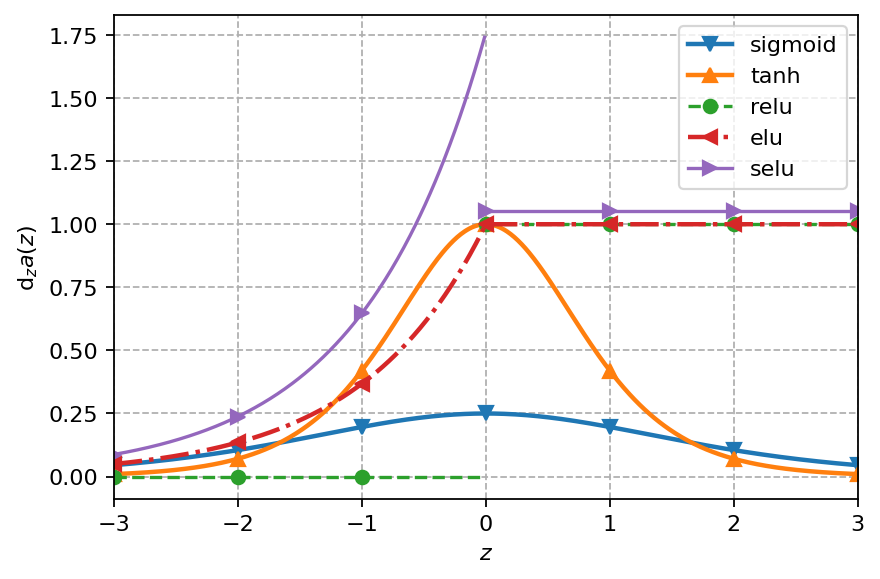

In [16]:
x = pt.autograd.Variable(pt.arange(-3, 3.01, 0.01), requires_grad=True)
marker = ["v", "^", "o", "<", ">"]
ls = ["-", "-", "--", "-.", "-"]
cont = [True, True, False, True, False]
color = ["C{:1d}".format(i) for i in range(len(activations))]
for i, func in enumerate(activations):
    res = func(x)
    res.backward(pt.ones(x.shape[0]))
    x_num = x.detach().numpy()
    grad_num =  x.grad.numpy()
    if cont[i]:
        plt.plot(x_num, grad_num,
            ls=ls[i], lw=2, marker=marker[i], markevery=100, color=color[i], label=func.__name__)
    else:
        plt.plot([xi for xi in x_num if xi <= 0.0], [dx for xi, dx in zip(x_num, grad_num) if xi <= 0.0],
                ls=ls[i], marker=marker[i], markevery=100, color=color[i], label=func.__name__)
        plt.plot([xi for xi in x_num if xi > 0.0], [dx for xi, dx in zip(x_num, grad_num) if xi > 0.0],
                ls=ls[i], marker=marker[i], color=color[i], markevery=100)
    x.grad.data.zero_()
    
plt.xlim(-3,3)
plt.xlabel(r"$z$")
plt.ylabel(r"$\mathrm{d}_za(z)$")
plt.grid(True, ls="--")
plt.legend()
plt.savefig(f"{output}/activation_slopes.svg", bbox_inches="tight")

Now it's time to implement a neural network class with some flexible design parameters in PyTorch. Most models in PyTorch inherit from the `Module` base class in the neural network (nn) module. The super class implements a few additional functions that simplify the network training, e.g., by collecting a list of trainable parameters. In the constructor, we accept a few parameters to shape the neural network. We can change the number of hidden layers, the number of neurons per layer, the activation function, and the number of inputs and outputs. This class provides a simple but very flexible and powerful generic function approximation tool. The forward function implements the prediction based on a given feature vector. If we have $N_s$ samples and the feature vector has a length of $N_f$, the input tensor in PyTorch must have the shape $N_s\times N_f$. The dimension with $N_s$ entries is also called the batch dimension (because we may provide the model with batches of data).

In [17]:
class SimpleNN(pt.nn.Module):
    """Simple fully-connected neural network.
    """
    def __init__(self, **kwargs):
        super().__init__()
        self.n_inputs = kwargs.get("n_inputs", 1)
        self.n_outputs = kwargs.get("n_outputs", 1)
        self.n_layers = kwargs.get("n_layers", 1)
        self.n_neurons = kwargs.get("n_neurons", 10)
        self.activation = kwargs.get("activation", pt.sigmoid)
        self.layers = pt.nn.ModuleList()
        # input layer to first hidden layer
        self.layers.append(pt.nn.Linear(self.n_inputs, self.n_neurons))
        # add more hidden layers if specified
        if self.n_layers > 1:
            for hidden in range(self.n_layers-1):
                self.layers.append(pt.nn.Linear(
                    self.n_neurons, self.n_neurons))
        # last hidden layer to output layer
        self.layers.append(pt.nn.Linear(self.n_neurons, self.n_outputs))

    def forward(self, x):
        for i_layer in range(len(self.layers)-1):
            x = self.activation(self.layers[i_layer](x))
        return self.layers[-1](x)

    @property
    def model_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

### Preparing the data

To demonstrate the training and evaluation of neural networks, we need some training data. Here, we work with developed velocity profiles of a 1D channel flow simulation. Conducting the parameter study to create the data is part of the accompanying exercise session. The channel flow is characterized by the Reynolds number $Re=\bar{2U\delta}/nu$, where $\delta$ is one half of the channel height, $\bar{U}$ is the average velocity along the channel, and $\nu$ is the kinematic viscosity. In the parameter study, 15 different values $ 10^4 < Re < 10^5$ were sampled and the corresponding simulations executed. The main output of the simulation is the velocity along the channel $U_x$ at several distances $y$ normal to the channel wall. Our goal is to create a model that provides us with a streamwise velocity value for a given distance from the wall and the Reynolds number:
$$
  U_{x} = f(y, Re).
$$
The features are $y$ and $Re$. The label is $U_x$.

As a first step, we load the velocity profiles, the points normal to the wall at which the velocity values are defined, and the Reynolds numbers.

In [18]:
cases = glob("../exercises/boundary_layer_1D_Ub_*")
cases = sorted(cases, key=lambda case: float(case.split("_")[-1]))
loader = FOAMDataloader(cases[0])
y = loader.vertices[:, 1]
Ux = pt.zeros((y.shape[0], len(cases)))
for i, case in enumerate(cases):
    loader = FOAMDataloader(case)
    Ux[:, i] = loader.load_snapshot("U", loader.write_times[-1])[:, 0]

Ubar = pt.tensor([float(case.split("_")[-1]) for case in cases])
print("Shape of data matrix: ", Ux.shape)

Could not find precomputed cell centers and volumes.
Computing cell geometry from scratch (slow, not recommended for large meshes).
To compute cell centers and volumes in OpenFOAM, run:

postProcess -func "writeCellCentres" -constant -time none
postProcess -func "writeCellVolumes" -constant -time none
Shape of data matrix:  torch.Size([200, 15])


There are 200 points normal to the wall and 15 different Reynolds numbers. Each velocity profile contains 200 values and all 15 profiles assembled yield a $200\times 15$ tensor. Since the data are low-dimensional, we have the luxury of being able to visualize the full dataset all at once.

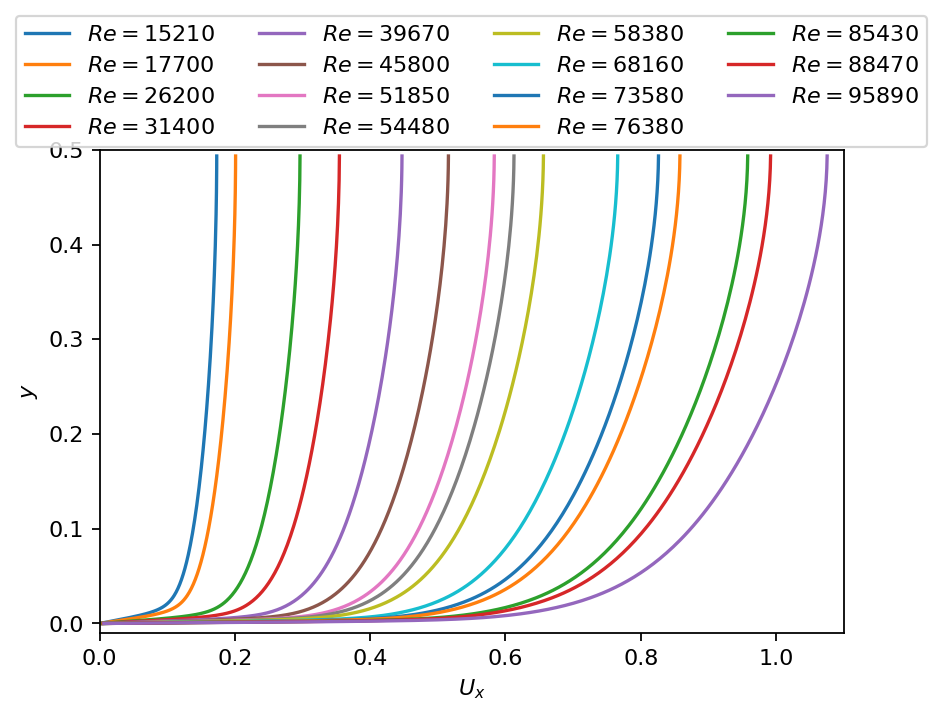

In [19]:
delta, nu = 0.5, 1.0e-5
Re = pt.tensor([Ub.item()*2*delta/nu for Ub in Ubar])
for i, Ub in enumerate(Ubar):
    plt.plot(Ux[:, i], y, label=r"$Re={:1.0f}$".format(round(Re[i].item(), 0)))
plt.xlabel(r"$U_x$")
plt.ylabel(r"$y$")
plt.xlim(0.0, 1.1)
plt.ylim(-0.01, 0.5)
plt.legend(loc="upper center", ncol=4, bbox_to_anchor=[0.5, 1.3])
plt.savefig(f"{output}/developed_1d_profile.svg", bbox_inches="tight")

A first inspection of the data shows the expected behavior. As the Reynolds number increases, the average channel velocity increases and the profiles become steeper close to the wall. These observations are a good first sanity check. However, we should validate the data against known results for the same or similar settings. Luckily, the problem is relatively simple such that we can compare the outcome against an existing analytical function. We know that close to the wall, the velocity profile should follow first a linear and then a logarithmic trend. This relation is know as [law of the wall](https://en.wikipedia.org/wiki/Law_of_the_wall). Spalding's function provides a single function reflecting both linear and logarithmic zones. However, Spalding's function is given in so-called inner coordinates:
$$
  u_\tau = \sqrt{\nu\partial_yU_x|_{y=0}/\rho},\quad y^+ = y\nu/u_tau,\quad u^+ = U_x/u_tau.
$$
The velocity $u_\tau$ is also called shear stress or friction velocity. Since the simulation is incompressible, we assume a unity density. Spalding's function is then given as:
$$
  y^+ = u^+ + \left[e^{u^+\kappa} - 1 - u^+\kappa\left(1+u^+\kappa/2\right) - \left(u^+\kappa\right)^3/6\right] / E,
$$
where the constants have values of $E=9.8$ and $\kappa = 0.41$.

To compare to Spalding's function, we have to convert the velocity profiles into inner coordinates. The velocity's slope at the wall $\partial_yU_x|_{y=0}$ can be approximated for each velocity using finite differences and assuming a velocity of zero at the wall. In the figure below, we can observe how the velocity profiles nicely collapse almost into a single line in agreement with Spalding's function.

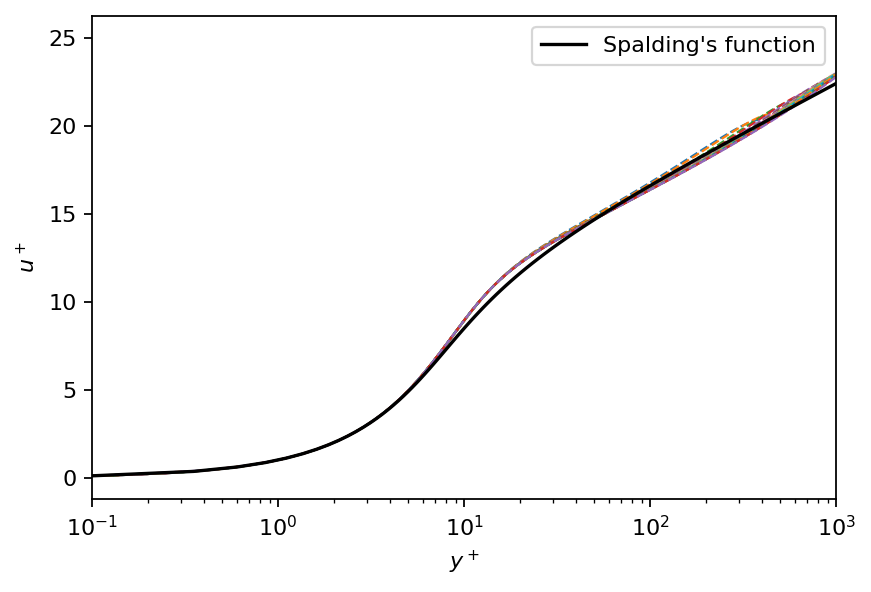

In [20]:
def spalding(up: pt.Tensor, E: float=9.8, kappa: float=0.41) -> pt.Tensor:
    """Compute Spalding's velocity profile.

    :param up: velocity in inner coordinates U-plus
    :type up: pt.Tensor
    :param E: wall roughness constant, defaults to 9.8
    :type E: float, optional
    :param kappa: van Kármán constant, defaults to 0.41
    :type kappa: float, optional
    :return: distance in inner coordinates y-plus
    :rtype: pt.Tensor
    """
    upk = up*kappa
    temp = pt.exp(upk) - 1 - upk*(1+upk/2) - upk**3/6
    return up + temp/E

dy_Ux = (0.0 - Ux[0, :]) / (0.0 - y[0])
U_tau = pt.sqrt(nu * dy_Ux)

for i, Ub in enumerate(Ubar):
    y_plus = y*U_tau[i]/nu
    U_plus = Ux[:, i] / U_tau[i]
    plt.plot(y_plus, U_plus, lw=1, ls="--")

U_spalding = pt.linspace(0.1, 25, 100)
plt.plot(spalding(U_spalding), U_spalding, c="k", label="Spalding's function")
plt.xlabel(r"$y^+$")
plt.ylabel(r"$u^+$")
plt.xlim(0.1, 1000)
plt.xscale("log")
plt.legend()
plt.savefig(f"{output}/1d_profile_inner.svg", bbox_inches="tight")

Next, we split the data into three parts. One part contains most of the data and will be used for optimizing the free parameters. The other two parts are significantly smaller and will be used to evaluate the training process. One of the smaller parts is meant to provide feedback during the optimization while the other one is only evaluated after the training is done. In summary, the data is split into:

- **training data**: used for optimization (training)
- **validation data**: used as sanity check during training
- **testing data**: used to score the final model

Note that the naming of testing and validation data is somewhat arbitrary and ML practitioners may use the terms interchangeably. For the simple problem considered here, it would not be really necessary to even split the data, because the problem is low-dimensional, and we can inspect the model's properties by means of standard visualization techniques. However, as the problems become high-dimensional, the split is essential to assess the model's characteristics. More about the assessment follows in the next section.

To split the data, we use a [multinomial](https://pytorch.org/docs/stable/generated/torch.multinomial.html) probability distribution. The multinomial probability distribution draws samples from discrete events (categories) according to a given list of probabilities for each category. We want to use the velocity profiles for two randomly selected Reynolds numbers for testing, another two Reynolds numbers for validation, and the remaining velocity profiles for training. Note that there are other sensible ways to split the data. The `pt.multinomial` function returns the indices of the drawn categories. In our case, there are 15 different categories, one for each Reynolds number. The probability tensor is initialized with ones, meaning that every category has the same chance of being drawn. We then draw two Reynolds numbers, set the corresponding indices of the probability tensor to zero, and repeat the process. It is important to note here that, by the implementation's defaults, no category will be drawn twice because the `replacement` parameter is set to `False`.

In [21]:
# select two snapshots for testing
probs = pt.ones(Ux.shape[-1])
test_idx = pt.multinomial(probs, 2)
probs[test_idx] = 0.0
val_idx = pt.multinomial(probs, 2)
probs[val_idx] = 0.0
train_idx = pt.multinomial(probs, probs.shape[0]-4)
print("Testing snapshots: ", test_idx)
print("Validation snapshots: ", val_idx)
print("Training snapshots: ", train_idx)

Testing snapshots:  tensor([ 7, 10])
Validation snapshots:  tensor([8, 2])
Training snapshots:  tensor([12, 14,  1,  6,  3,  0,  9,  4,  5, 13, 11])


The final preparation steps are reshaping and normalizing the data. Currently, we have the distance normal to the wall, the Reynolds numbers, and the velocity profiles in separate data structures. However, the data structure needed to train a model $U_x = f(y, Re)$ looks as follows:

| $U_x$ | $y$ | $Re$ |
|:-----:|:---:|:----:|
| $0.131$ | $0.0001$ | $98362$ |
| $0.201$ | $0.0002$ | $98362$ |
| ... | ... | ... |

The order of the columns is arbitrary and we could also separate the label $U_x$ from the two features $y$ and $Re$. For $N_r$ selected Reynolds number/profiles and $N_y$ points per profile, the resulting dataset tensor should have $N_r\times N_y$ rows and three columns.

To mitigate the effect of roundoff errors, we normalize the data such that $ \tilde{U}_x, \tilde{y}, \tilde{Re} \in[-1,1]$. Since we already split the data, it is important to mention that all datasets have to be scaled with the same minimum and maximum values. To simplify this process, the `MinMaxScaler` class has a `fit` function to set up the scaler and then, we can use its `scale` and `rescale` function to transform different datasets with the same extreme values.

In [22]:
def reshape_data(Ux: pt.Tensor, y: pt.Tensor, Re: pt.Tensor) -> pt.Tensor:
    """Create feature and label vectors.

    :param Ux: velocity profiles; first dimension corresponds to the
        distance y; second dimension corresponds to Reynolds number
    :type Ux: pt.Tensor
    :param y: distance from the wall; order from lowest to largest
    :type y: pt.Tensor
    :param Re: Reynolds number based on average velocity, channel height,
        and kinematic viscosity
    :type Re: pt.Tensor
    :return: data suitable for training; if there are Ny points normal to
        the wall and Nr different Reynolds numbers, the resulting tensor
        has the shape (Ny*Nr, 3)
    :rtype: pt.Tensor
    """
    assert Ux.shape[1] == Re.shape[0]
    assert Ux.shape[0] == y.shape[0]
    data = pt.zeros((Ux.shape[0]*Ux.shape[1], 3))
    for i in range(Ux.shape[1]):
        start, end = i*Ux.shape[0], (i+1)*Ux.shape[0]
        data[start:end, 0] = Ux[:, i]
        data[start:end, 1] = y
        data[start:end, 2] = Re[i]
    return data


class MinMaxScaler(object):
    """Class to scale/re-scale data to the range [-1, 1] and back.
    """
    def __init__(self):
        self.min = None
        self.max = None
        self.trained = False

    def fit(self, data):
        self.min = data.min(dim=0).values
        self.max = data.max(dim=0).values
        self.trained = True

    def scale(self, data):
        assert self.trained
        assert len(data.shape) == 2
        data_norm = (data - self.min) / (self.max - self.min)
        return 2.0*data_norm - 1.0

    def rescale(self, data_norm):
        assert self.trained
        assert len(data_norm.shape) == 2
        data = (data_norm + 1.0) * 0.5
        return data * (self.max - self.min) + self.min

In [23]:
test_data = reshape_data(Ux[:, test_idx], y, Re[test_idx])
val_data = reshape_data(Ux[:, val_idx], y, Re[val_idx])
train_data = reshape_data(Ux[:, train_idx], y, Re[train_idx])

The code box below contains some tests to verify that the normalization is working. When comparing floating point number against one another, it is always better to check that their absolute difference is below a certain tolerance rather than checking for exact equality (roundoff errors!). PyTorch has some convenient functions to compare two scalar-valued tensors, `isclose`, or every pair of values in two higher-order tensors, `allclose`.

In [24]:
scaler = MinMaxScaler()
scaler.fit(train_data)
train_data_norm = scaler.scale(train_data)
val_data_norm = scaler.scale(val_data)
test_data_norm = scaler.scale(test_data)
assert pt.isclose(train_data_norm.min(), pt.tensor(-1.0))
assert pt.isclose(train_data_norm.max(), pt.tensor(1.0))
assert pt.allclose(train_data, scaler.rescale(train_data_norm))

### Optimizing the model weights

To optimize the network's parameters $\mathbf{p}$, we need a metric expressing how good the model's prediction is. The most common metric used for regression problems is the mean squared error (MSE), also referred to as $L_2$ norm/loss. For a set of $N$ generic pairs of feature vectors $\mathbf{x}_i$ and label vectors $\mathbf{y}_i$, the $L_2$ loss is defined as:
$$
  L_2(\mathbf{p}) = \frac{1}{N}\sum\limits_{i=1}^N \left( \mathbf{y}_i - f_{\mathbf{p}}(\mathbf{x}_i) \right)^2,
$$
where $f_{\mathbf{p}}(\mathbf{x})$ is the model with weights $\mathbf{p}$ and $ \hat{\mathbf{y}}_i = f_{\mathbf{p}}(\mathbf{x}_i) $ is the prediction for the $i$ th feature vector instance. The goal of the parameter optimization/training is to find the parameter configuration yielding the minimal loss:
$$
  \underset{\mathbf{p}}{\mathrm{argmin}} L_2 (\mathbf{p}).
$$

The `optimize_model` function below implements a gradient decent optimization loop to minimize a model's error based on the MSE loss. The variant of gradient decent used here is called [ADAM](https://arxiv.org/abs/1412.6980), which is an empirically enhanced version of the standard gradient decent algorithm for faster and more robust training.

In general, the loss function of a neural network will be nonlinear and non-convex. Therefore, the loss values typically does not decreases monotonically but is subjected to oscillations (the optimization processes is *jumping* over local minima). If we perform a fixed number of optimization epochs/iterations, the final parameter configuration is not necessarily the best one. A simple strategy to keep the best model is to compare the current loss value against the best loss values encountered during the training. If a new best loss is reached, a snapshot of the model is saved. After the training, we load and evaluate only the best model.

In [25]:
def optimize_model(model: pt.nn.Module, x_train: pt.Tensor, y_train: pt.Tensor,
                   x_val: pt.Tensor, y_val: pt.Tensor, epochs: int=1000,
                   lr: float=0.001, save_best: str="") ->Tuple[List[float], List[float]]:
    """Optimize network weights based on training and validation data.

    :param model: neural network model
    :type model: pt.nn.Module
    :param x_train: features for training
    :type x_train: pt.Tensor
    :param y_train: labels for training
    :type y_train: pt.Tensor
    :param x_val: features for validation
    :type x_val: pt.Tensor
    :param y_val: labels for validation
    :type y_val: pt.Tensor
    :param epochs: number of optimization loops, defaults to 1000
    :type epochs: int, optional
    :param lr: learning rate, defaults to 0.001
    :type lr: float, optional
    :param save_best: path where to save best model; no snapshots are saved
        if empty string; defaults to ""
    :type save_best: str, optional
    :return: lists with training and validation losses for all epochs
    :rtype: Tuple[List[float], List[float]]
    """
    criterion = pt.nn.MSELoss()
    optimizer = pt.optim.Adam(params=model.parameters(), lr=lr)
    best_val_loss, best_train_loss = 1.0e5, 1.0e5
    train_loss, val_loss = [], []
    for e in range(1, epochs+1):
        optimizer.zero_grad()
        prediction = model(x_train).squeeze()
        loss = criterion(prediction, y_train)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        with pt.no_grad():
            prediction = model(x_val).squeeze()
            loss = criterion(prediction, y_val)
            val_loss.append(loss.item())
        print("\r", "Training/validation loss epoch {:5d}: {:10.5e}, {:10.5e}".format(
            e, train_loss[-1], val_loss[-1]), end="")
        if isdir(save_best):
            if train_loss[-1] < best_train_loss:
                pt.save(model.state_dict(), f"{save_best}best_model_train.pt")
                best_train_loss = train_loss[-1]
            if val_loss[-1] < best_val_loss:
                pt.save(model.state_dict(), f"{save_best}best_model_val.pt")
                best_val_loss = val_loss[-1]
    return train_loss, val_loss


It's finally time to train our first model! We instantiate a relatively small network with two hidden layers, 40 neurons per layer, and ReLU activation functions. Let's see how the training works out.

In [26]:
save_model_in = f"{output}/first_training/"
!mkdir -p $save_model_in
model_params = {
    "n_inputs": 2,
    "n_outputs": 1,
    "n_layers": 2,
    "n_neurons": 40,
    "activation": pt.nn.ReLU()
}
model = SimpleNN(**model_params)
train_loss, val_loss = optimize_model(model, train_data[:, 1:], train_data[:, 0],
                                      val_data[:, 1:], val_data[:, 0], 10000, save_best=save_model_in)


 Training/validation loss epoch 10000: 3.68497e-02, 2.44188e-02

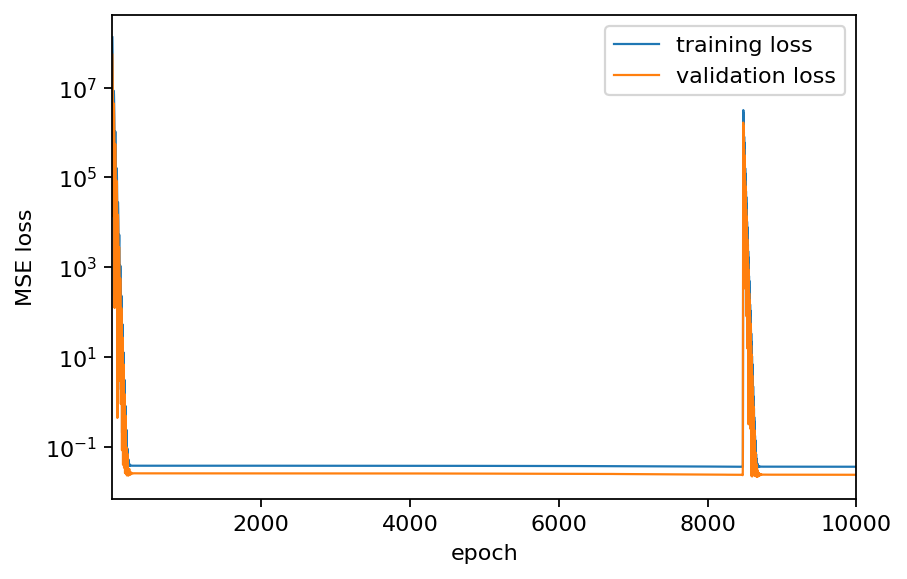

In [27]:
epochs = len(train_loss)
plt.plot(range(1, epochs+1), train_loss, lw=1.0, label="training loss")
plt.plot(range(1, epochs+1), val_loss, lw=1.0, label="validation loss")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.xlim(1, epochs+1)
plt.yscale("log")
plt.legend()
plt.savefig(f"{output}/train_val_loss_unscaled.svg", bbox_inches="tight")

The first trial went pretty bad. The loss did not really decrease during most of the iterations and jumped up by several orders of magnitude towards the end of the optimization. What went wrong? You may have noticed already that, by mistake, we used the **unscaled** data for training. Let's see if the performance improves with the normalized data.

In [28]:
model = SimpleNN(**model_params)
train_loss, val_loss = optimize_model(model, train_data_norm[:, 1:], train_data_norm[:, 0],
                                      val_data_norm[:, 1:], val_data_norm[:, 0], 10000, save_best=save_model_in)


 Training/validation loss epoch 10000: 3.76100e-05, 2.26089e-04

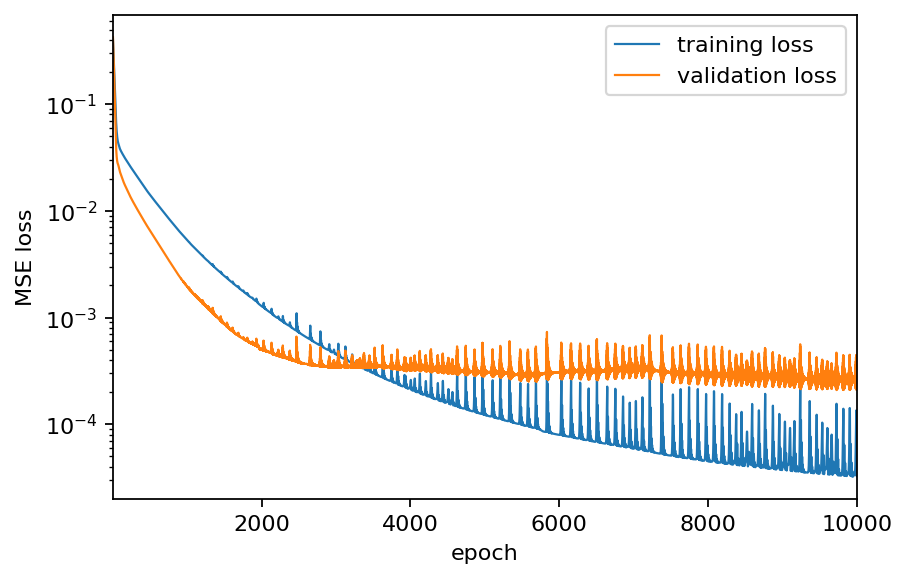

In [29]:
epochs = len(train_loss)
plt.plot(range(1, epochs+1), train_loss, lw=1.0, label="training loss")
plt.plot(range(1, epochs+1), val_loss, lw=1.0, label="validation loss")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.xlim(1, epochs+1)
plt.yscale("log")
plt.legend()
plt.savefig(f"{output}/train_val_loss.svg", bbox_inches="tight")

Much better! The loss would probably keep decreasing if we continued the training. You may have noticed that the validation after about 3000 epochs decreased only very slowly. The discrepancy between training and validation loss is a first indicator for a potential over-adjustment (over-fitting) of the model to the data. However, in the present case, the validation keeps improving slowly. It might be that the gap between both loss values would decrease if we ran more training epochs. Over-fitting to the data is more likely if:

- there are not sufficient data; the shear size of the data is not the only criterion; the data must be also distributed homogeneously in the feature and label spaces
- the problem is high-dimensional; the amount of data needed to train an accurate model increases, in the worst case, exponentially with the problem's dimensionality
- the model has many free parameters
 
 One strategy to avoid over-fitting is to stop the training early, e.g., when validation and training loss start to diverge. The optimization loop defined before saves snapshots for both minimal training and minimal validation loss. We could compare both models and evaluate if their performance on the testing data differs (consider it as an exercise). As you can see below, the best model's assessment on the testing data is somewhere between the best training and validation loss. In the addition to the $L_2$ loss, it is always sensible to monitor the maximum error, too. One suitable option is the maximum norm defined as:
$$
  L_\infty = \mathrm{max} | \mathbf{y}_i - \hat{\mathbf{y}}_i | / (\mathbf{y}_{max} - \mathbf{y}_{min}),\quad i \in \left\{1, 2, ..., N\right\},
$$
where $\mathbf{y}_{min}$ and $\mathbf{y}_{max}$ are vectors with the minimum and maximum values for each label $y_j$, respectively. The normalization is optional and problem dependent to some extend. In the code cell below, the maximum error is computed based on the scaled label for simplicity.

In [30]:
best_model = SimpleNN(**model_params)
best_model.load_state_dict(pt.load(f"{save_model_in}best_model_train.pt"))
prediction = best_model(test_data_norm[:, 1:]).squeeze()
l2 = (prediction - test_data_norm[:, 0]).square().mean()
# we normalize the maximum error with the range of the scaled Ux,
# which is 1-(-1)=2
lmax = (prediction - test_data_norm[:, 0]).absolute().max() / 2
print("MSE test loss: {:1.4e}".format(l2))
print("Lmax test loss: {:1.4e}".format(lmax))

MSE test loss: 1.3294e-04
Lmax test loss: 2.2487e-02


Let's have a look at the final model. We plot the full dataset together with the model's prediction. The general trend predicted by the model seems OK for a first trial. There are a few oscillations in the prediction, which are not present in the reference data. Several strategies could be employed the improve the model'S performance further:

- repeat the training, potentially with more epochs
- tuning of the model's design parameters and other hyper parameters like the learning rate
- design of additional features based on physical relations we are aware of (part of the exercise)

Before any of the suggestions above is followed, it is essential to understand one more critical characteristic of DL, which is the topic of the next section.

In [31]:
full_data = reshape_data(Ux, y, Re)
full_data_norm = scaler.scale(full_data)
full_pred = best_model(full_data_norm[:, 1:]).squeeze()
# re-use full dataset for rescaling; it would be better
# to have separate scalers for features and labels
full_data_norm[:, 0] = full_pred
prediction = scaler.rescale(full_data_norm).detach()

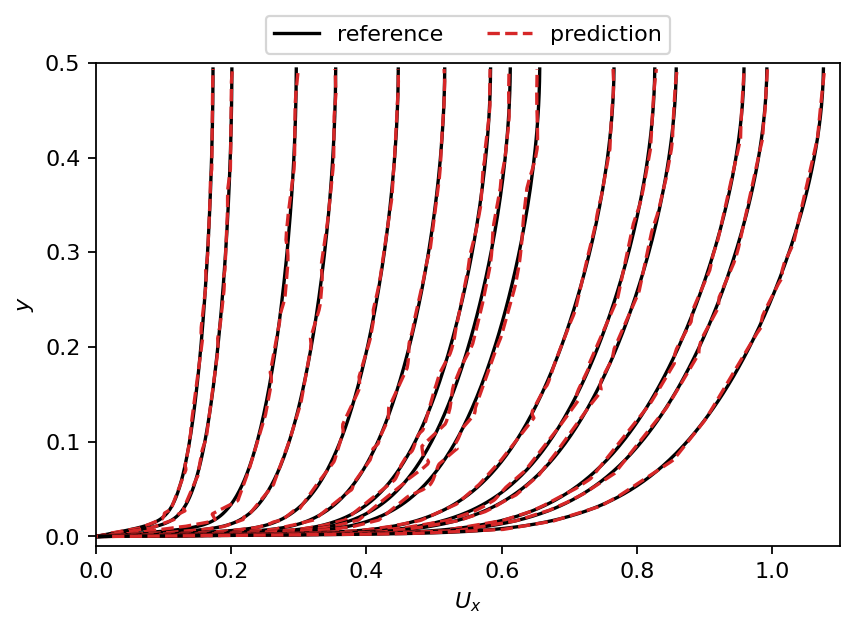

In [32]:
n_points = y.shape[0]
plt.plot([], label="reference", c="k")
plt.plot([], label="prediction", c="C3", ls="--")
for i, Ub in enumerate(Ubar):
    plt.plot(Ux[:, i], y, c="k")
    plt.plot(prediction[i*n_points:(i+1)*n_points, 0], y, ls="--", c="C3")
plt.xlabel(r"$U_x$")
plt.ylabel(r"$y$")
plt.xlim(0.0, 1.1)
plt.ylim(-0.01, 0.5)
plt.legend(loc="upper center", ncol=2, bbox_to_anchor=[0.5, 1.12])
plt.savefig(f"{output}/profile_pred_vs_org.svg", bbox_inches="tight")

### Dealing with uncertainty

The training of neural networks is not deterministic. If you go back to the cell in which the model training was performed and execute the cell several times, every time you will end up with a different model and a different loss behavior. The reason for this observation is twofold:

1. the loss function is non-convex
2. the initial values for $\mathbf{p}$ are sampled randomly

Basically, we end up in different local minima in each training run. Fortunately, the situation is not as bad as it seems, because neural networks tend to have many local minima yielding good models. Nonetheless, if we want to rigorously compare two different neural networks, we have to deal with the uncertainty of the training as we would it in a real work experiment. We repeat the training several times and compare different models on a statistical basis, e.g., by comparing mean, median, or standard deviation over all runs. In the example below, we evaluate the influence of the selected activation function on the best $L_2$ loss. To keep the training time small, only 1000 training epochs are performed, and the training with each activation function is repeated ten times.

In [33]:
def eval_best_model(model: pt.nn.Module, features: pt.Tensor,
                    label: pt.Tensor, path: str) -> float:
    """Helper function to load and evaluate model snapshot.

    :param model: neural network model
    :type model: pt.nn.Module
    :param features: feature tensor
    :type features: pt.Tensor
    :param label: label tensor
    :type label: pt.Tensor
    :param path: location where the best model is stored
    :type path: str
    :return: mean squared prediction error
    :rtype: float
    """
    model.load_state_dict(pt.load(f"{path}best_model_train.pt"))
    prediction = model(features).squeeze()
    return (prediction - label).square().mean().detach().item()

In [34]:
save_temp = f"{output}/temp/"
!mkdir -p $save_temp
activations = [pt.sigmoid, pt.tanh, pt.nn.ELU(), pt.nn.ReLU(), pt.nn.SELU()]
losses = [[], [], [], [], []]
for i, activation in enumerate(activations):
    model_params["activation"] = activation
    for seed in range(10):
        pt.manual_seed(seed)
        model = SimpleNN(**model_params)
        _, _ = optimize_model(model, train_data_norm[:, 1:], train_data_norm[:, 0], val_data_norm[:, 1:],
                              val_data_norm[:, 0], 1000, save_best=save_temp)
        losses[i].append(
            eval_best_model(
                model, train_data_norm[:, 1:], train_data_norm[:, 0], save_temp)
        )

 Training/validation loss epoch  1000: 6.91025e-03, 2.49548e-03

[Box plots](https://en.wikipedia.org/wiki/Box_plot) present a very rich visualization of groups of data. In the figure below, we compare the box plots resulting from the different activation functions. Box plots mainly work with quantiles. The $p$ th quantile, denoted by $q_p$, is obtained by sorting the data and then counting through the data until $p\%$ of the overall number of data points are reached. For example, the $50$ th quantile of the set $\{ 3, 1, 5, 4, 2\}$ would be $q_{50} = 2$. The $50\%$ quantile is commonly called median. In a box plot, the lower and upper boundaries of the box are given by the $25$ th and $75$ th quantiles, respectively. The orange line in the plot below indicates the median. Quantiles are also used to identify outliers. The inter quantile range (IQR) is defined as $q_r = q_{75} - q_{25}$. Outlier detection based on the IQR assumes that values in the range $q_{25}-kq_r \le x \le q_{75}+kq_r$ are regular values, whereas values outside this range are outliers. The factor $k$ is often chosen as $k=1.5$. Outliers in the plot below are indicated by red circles. The so-called whiskers (the little antennas extending from the box) indicate the largest and smallest values not considered to be outliers. From box plots, we can infer the spread of the data and also how it is distributed. For example, if the whiskers are symmetric and the median is in the middle of the box, the data are normally distributed (approximately).

The plot below indicates that all activation function perform better than the sigmoid function in terms of $L_2$ loss and also the spread of the training's outcome (the difference between different training runs varies much stronger). Overall, the ReLU activation function fairs the best in this numerical experiment.

In ML research, we want our experiments to be repeatable, even if random sampling is part of the process. Luckily, there are no true random numbers in computer programs. Instead, they are said to be *pseudo random*, because we can define a so-called *seed* parameter that makes the sampling repeatable. In the inner loop of the code cell above, we use the loop count as seed. Therefore, the initial weights change for each training with one particular activation function. However, the $i$ th training with each activation function starts from the same initial weights.

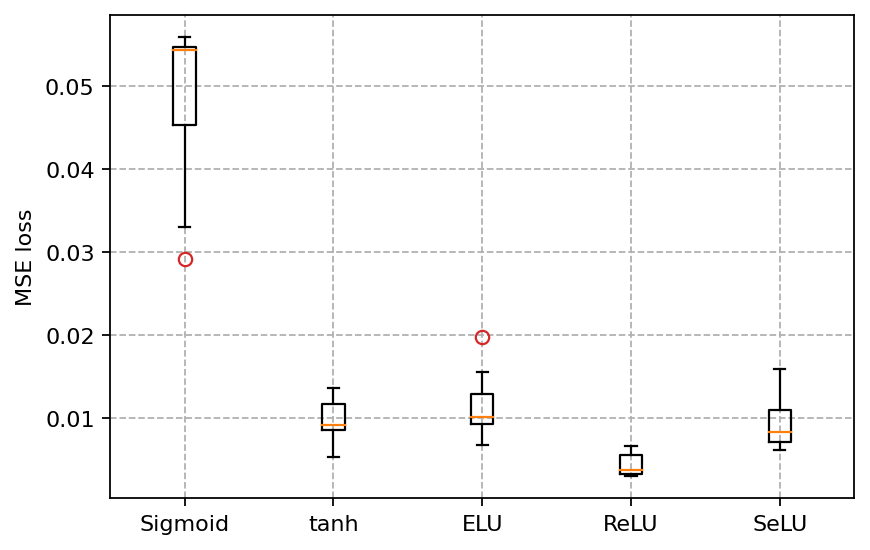

In [35]:
for i in range(len(losses)):
    plt.boxplot(np.array(losses[i]), positions=[i], flierprops={
                "markersize": 6, "markeredgecolor": "C3"})

plt.gca().set_xticklabels(["Sigmoid", "tanh", "ELU", "ReLU", "SeLU"])
plt.ylabel("MSE loss")
plt.grid(ls="--")
plt.savefig(f"{output}/profile_activations.svg", bbox_inches="tight")

An important design parameter to change the model's flexibility (the ability to fit data) is the number of hidden layers. In the code cell below, we conduct a similar experiment as before but vary only the number of hidden layers. As can be seen in the box plots, the loss and also the spread of the loss decreases significantly as the number of hidden layers increases. Moreover, the improvement in the $L_2$ loss seems to become smaller and smaller with each additional hidden layers.

In [36]:
save_temp = f"{output}/temp/"
!mkdir -p $save_temp
layers = [1, 2, 3, 4]
losses = [[], [], [], []]
model_params["activation"] = pt.nn.ReLU()
for i, nl in enumerate(layers):
    model_params["n_layers"] = nl
    for seed in range(10):
        pt.manual_seed(seed)
        model = SimpleNN(**model_params)
        _, _ = optimize_model(model, train_data_norm[:, 1:], train_data_norm[:, 0], val_data_norm[:, 1:],
                              val_data_norm[:, 0], 1000, save_best=save_temp)
        losses[i].append(
            eval_best_model(
                model, train_data_norm[:, 1:], train_data_norm[:, 0], save_temp)
        )

 Training/validation loss epoch  1000: 4.14651e-04, 4.13284e-04

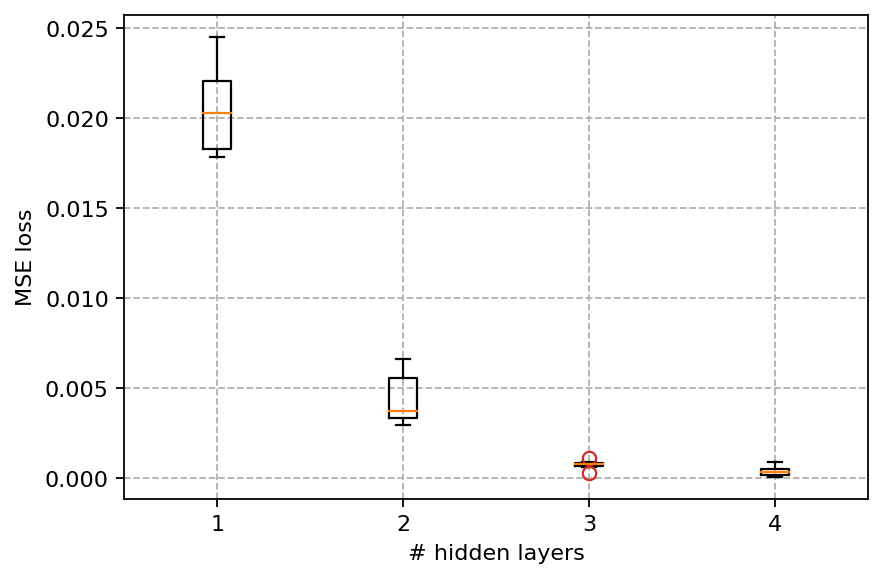

In [37]:
for i in range(len(losses)):
    plt.boxplot(np.array(losses[i]), positions=[layers[i]], flierprops={
                "markersize": 6, "markeredgecolor": "C3"})

plt.xlabel("# hidden layers")
plt.ylabel("MSE loss")
plt.grid(ls="--")
plt.savefig(f"{output}/profile_layers.svg", bbox_inches="tight")

### Visualizing prediction errors

As mentioned before, it is relatively easy to assess the model's behavior for the present problem. For high-dimensional parameter spaces, the evaluation is less straightforward, and we have to rely on statistics and other less intuitive means of visualization. Two techniques are demonstrated below:

- a histogram of the prediction error; the histogram shows how the error is distributed; ideally, all prediction errors should be located in a narrow band around zero; we can immediately read the maximum prediction errors and infer how many predictions yield such high errors
- a heatmap with the maximum prediction errors in different sub-sections of the feature space; if we had more features, we would create the same plot for the two most important features, or we would create several heatmaps for different combinations of features; the heatmap indicates which sections of the feature space yield high prediction errors; in the example below we see that prediction errors are high for small distances and large Reynolds numbers

In [38]:
model = SimpleNN(**model_params)
model.load_state_dict(pt.load(f"{save_temp}best_model_train.pt"))
prediction = model(full_data_norm[:, 1:]).squeeze().detach()
error = (prediction - full_data_norm[:, 0]) / 2 * 100

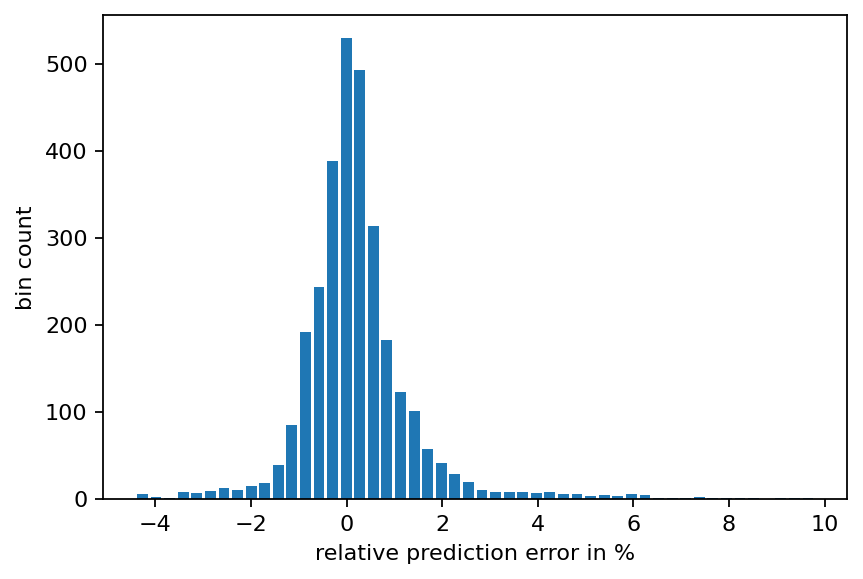

In [39]:
err_min = error.min().item()
err_max = error.max().item()
counts = pt.histc(error, bins=50, min=err_min, max=err_max).detach()
bin_width = (err_max-err_min) / 50
centers = pt.arange(err_min+0.5*bin_width, err_min +
                    50*bin_width, bin_width).detach()

plt.bar(centers, counts, width=bin_width*0.8)
plt.xlabel("relative prediction error in %")
plt.ylabel("bin count")
plt.savefig(f"{output}/profile_error_hist.svg", bbox_inches="tight")

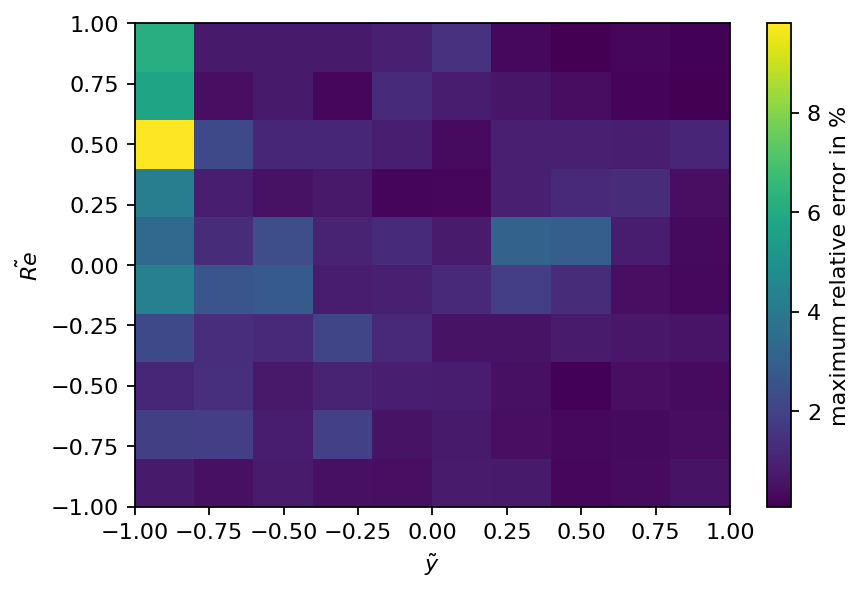

In [40]:
def max_error_map(x: pt.Tensor, err: pt.Tensor, bins: int) -> pt.Tensor:
    """Divide feature space in bins and compute maximum error for each bin.

    :param x: feature tensor
    :type x: pt.Tensor
    :param err: absolute error values
    :type err: pt.Tensor
    :param bins: number of bin
    :type bins: int
    :return: 2D tensor with maximum errors for each bin; if there are N bins,
        the result will be a NxN tensor
    :rtype: pt.Tensor
    """
    step = 2.0 / bins
    bounds_low = pt.arange(-1, 1.0, step)
    bounds_up = pt.arange(-1+step, 1.0+0.5*step, step)
    max_error = pt.zeros((bins, bins))
    for i, (low_i, up_i) in enumerate(zip(bounds_low, bounds_up)):
        for j, (low_j, up_j) in enumerate(zip(bounds_low, bounds_up)):
            errors = pt.where((x[:, 0] >= low_i) & (x[:, 1] >= low_j) & (
                x[:, 0] < up_i) & (x[:, 1] < up_j), err.type(pt.float64), 0.0)
            max_error[i, j] = errors.max()
    return max_error


error_map = max_error_map(full_data_norm[:, 1:], error.abs(), 10)
edges = pt.linspace(-1, 1, 10+1)
xx, yy = pt.meshgrid(edges, edges)
pcol = plt.pcolormesh(xx.detach(), yy.detach(), error_map.detach())
plt.colorbar(pcol, label=r"maximum relative error in %")
plt.xlabel(r"$\tilde{y}$")
plt.ylabel(r"$\tilde{Re}$")
plt.savefig(f"{output}/profile_error_heatmap.svg", bbox_inches="tight")

### Outlook

There are many topics, which we did not cover at all or not in great detail in this introduction. Some more topics will be covered in the following exercise sessions and lectures:

- feature design: we will design plenty of new features to embed mathematical constraints and physical relations
- batch training: the training data is split into batches, and the weights are updated after processing each batch (the network's weights are updated several times within a single training epoch)
- training on hardware accelerators: PyTorch supports model training on GPUs and other accelerators; GPU-based training often reduces the training time by a large margin